# QWOP AI

Direct screen capture for observation. Make sure QWOP is in Chrome and window is resized just before scroll bars appear. Place window in top-left of screen. Note that this project is intended to be run *locally* on a computer where you can easily set up the game window for screen capture.

Based on the "Build a Chrome Dino Game AI Model with Python" video by Nicholas Renotte: https://www.youtube.com/watch?v=vahwuupy81A

## Install dependencies

### Prerequisites

You will need to install OpenCV. The easiest way to do this is from the Anaconda environment. The newest version might work, but 4.7.0 worked for this notebook.

```
conda install -c conda-forge opencv=4.7.0
```

Additionally, you will need to install Tesseract on your computer. For Windows, install the executable from here: https://github.com/UB-Mannheim/tesseract/wiki. Then, add the folder with *tesseract.exe* to your PATH. pytesseract is just a Python wrapper, and it requires tesseract to be on the system path.

Finally, you will need to install PyTorch for Stable Baselines3 to work. It is highly recommended that you use the GPU-enabled version of PyTorch for faster training. Follow the directions here: https://pytorch.org/get-started/locally/. This notebook was tested with the following:
 * PyTorch v2.0.0
 * OS: Windows
 * Package: Conda
 * Language: Python
 * Compute platform: CUDA 11.7

### Install packages

Uncomment the following cells to install the required packages. Note the versions on some of them. Gymnasium and Stable-Baselines3 change constantly, so I tried to version-lock these packages, as these are known to work with this notebook. Starting with v2.0.0, Stable-Baselines3 will only support gymnasium (and drop gym support). See [here](https://github.com/DLR-RM/stable-baselines3/releases/tag/v1.8.0) for more information.

In [111]:
# !python -m pip install mss pynput pytesseract
# !python -m pip install gymnasium==0.28.1
# !python -m pip install stable-baselines3[extra]==2.0.0a1
# !python -m pip install wandb

## Configuration

In [112]:
### Import libraries

# Screen capture
from mss import mss

# Sending commands (e.g. mouse/keyboard)
import pynput

# OpenCV for image manipulation
import cv2

# Optical character recognition (OCR)
import pytesseract

# Farama Foundation Gymnasium (fork of OpenAI gym)
import gymnasium as gym

# Reinforcement model modules
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import PPO

# Weights & Biases for remote logging
import wandb

# Other
import time
import os
import numpy as np
from matplotlib import pyplot as plt

In [70]:
### Settings

# Game observation
GAME_CROP = {
    'top':430, 
    'left':300, 
    'width':480, 
    'height':320
}

# Image resize (minimum of 36x36 for default CnnPolicies)
GAME_RESIZE_WIDTH = 36
GAME_RESIZE_HEIGHT = 36

# How big to make display image (0 for no display)
DISP_SCALE_FACTOR = 8.0

# Score observation
SCORE_CROP = {
    'top':395, 
    'left':342, 
    'width':380, 
    'height':42
}

# Game over screen
DONE_CROP = {
    'top':635, 
    'left':430, 
    'width':220, 
    'height':38}
GAME_OVER_STRINGS = ["press"]

# Action settings
RESTART_MOUSE_POS = (300, 600)
RESTART_KEY = 'r'
ACTIONS_KEY_PRESS_TIME = 0.05
ACTIONS_MAP = {
    0:'no-op',
    1:'q',
    2:'w',
    3:'o',
    4:'p'
}

# CnnPolicy requires 8-bit unsigned integers for images
DTYPE = np.uint8

# Where to save model checkpoints and logs
CHECKPOINT_DIR = "checkpoints"
LOG_DIR = "logs"

In [ ]:
# Log in to Weights & Biases
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

## Test Screen Capture

Figure out how to set the crops and OCR.

In [4]:
### Create screen capture object
screen = mss()

Shape: (1, 36, 36)
Example row: [65 69 65 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34 34 34 34 63  1 63]


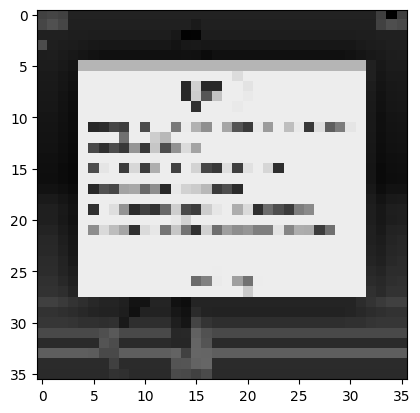

In [5]:
### Do screen grab and preprocess (make sure runner and some distance ahead is visible)

# Get screen grab and drop alpha channel
game_img = screen.grab(GAME_CROP)
game_img = np.array(game_img)[:, :, :3]

# Convert to grayscale and resize
game_img = cv2.cvtColor(game_img, cv2.COLOR_BGR2GRAY)
game_img = cv2.resize(game_img, (GAME_RESIZE_WIDTH, GAME_RESIZE_HEIGHT))

# Add channel dimension first (in case you want RGB later)
game_img = np.reshape(game_img, (1, GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH))

# Show crop/resized
print(f"Shape: {game_img.shape}")
print(f"Example row: {game_img[0, 0, :]}")
plt.imshow(game_img[0], cmap='gray', vmin=0, vmax=255)

# Try showing image in new window
if DISP_SCALE_FACTOR > 0:
    disp_width = int(GAME_RESIZE_WIDTH * DISP_SCALE_FACTOR)
    disp_height = int(GAME_RESIZE_HEIGHT * DISP_SCALE_FACTOR)
    disp_img = cv2.resize(game_img[0], (disp_width, disp_height), interpolation=cv2.INTER_AREA)
    cv2.namedWindow('Game Image')
    cv2.imshow('Game Image', disp_img)
    cv2.waitKey(2000)
    cv2.destroyAllWindows()

OCR string: 0.3 metres
Score: 0.3


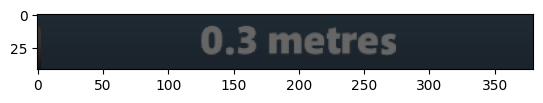

In [6]:
### Use OCR to get score

# Get screen grab and drop alpha channel
score_img = screen.grab(SCORE_CROP)
score_img = np.array(score_img)[:, :, :3]

# Convert to RGB
score_img = cv2.cvtColor(score_img, cv2.COLOR_BGR2RGB)

# Do OCR to get distance traveled
ocr_str = pytesseract.image_to_string(score_img).strip()
score = 0.0
if ocr_str:
    score_str = ocr_str.split()[0]
    try:
        score = float(float(score_str))
    except ValueError:
        pass
print(f"OCR string: {ocr_str}")
print(f"Score: {score}")

# Show image
plt.imshow(score_img)

OCR string: click to begin
Done: False


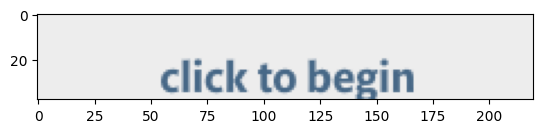

In [7]:
### Use OCR to get done screen

# Get screen grab and drop alpha channel
done_img = screen.grab(DONE_CROP)
done_img = np.array(done_img)[:, :, :3]

# Convert to RGB
done_img = cv2.cvtColor(done_img, cv2.COLOR_BGR2RGB)

# Do OCR to see if game is over
ocr_str = pytesseract.image_to_string(done_img).strip()
done = False
if ocr_str:
    done_str = ocr_str.split()[0]
    if done_str in GAME_OVER_STRINGS:
        done = True
print(f"OCR string: {ocr_str}")
print(f"Done: {done}")

# Show image
plt.imshow(done_img)

## Test Spaces

The gymnasium Environment (Env) requires us to define the observation space and action space so it can know what kinds of data to expect when it interacts with the environment. For us, the observation space is the shape and bit width of the normalized, scaled screen capture (our runner and some space in front of them). The action space is all the available actions we can input into the game (q, w, o, p) along with doing nothing (no-op). We should also test the ability to restart the game (pressing space bar).

In [8]:
### Test observation space

# Create an observation space
observation_space = gym.spaces.Box(low=0.0,
                                   high=1.0,
                                   shape=(1, GAME_RESIZE_WIDTH, GAME_RESIZE_WIDTH),
                                   dtype=np.float32)

# Randomly sample from it to show that it matches our expected input screen capture
obs = observation_space.sample()
print(f"Shape: {obs.shape}")
print(f"Example row: {obs[0, 0, :]}")

Shape: (1, 36, 36)
Example row: [0.30307448 0.6152972  0.3361057  0.39972392 0.3173872  0.87015116
 0.28006145 0.48331046 0.07657255 0.6168964  0.21375388 0.5081604
 0.9329158  0.08598229 0.20650311 0.36280677 0.80709714 0.99924284
 0.90156794 0.7650257  0.19275418 0.21843858 0.8093613  0.9400029
 0.32588732 0.14759406 0.8694135  0.4329541  0.5673459  0.00507227
 0.34072825 0.6850385  0.47350422 0.20579985 0.26277533 0.4717223 ]


In [9]:
### Test action space

# Create an action space
action_space = gym.spaces.Discrete(len(ACTIONS_MAP))

# Sample from it to show that we can randomly generate a number corresponding to an action
action = action_space.sample()
print(f"{action}: {ACTIONS_MAP[action]}")

2: w


In [10]:
### Test control interaction: reset game and do some random stuff

# Create interaction objects
keyboard = pynput.keyboard.Controller()
mouse = pynput.mouse.Controller()

# Move mouse to QWOP window and click to bring to focus
mouse.position = RESTART_MOUSE_POS
mouse.press(pynput.mouse.Button.left)
mouse.release(pynput.mouse.Button.left)

# Press 'r' to restart game
keyboard.press(RESTART_KEY)
keyboard.release(RESTART_KEY)

# Sample randomly from our action space to control the game
for _ in range(10):
    action = action_space.sample()
    if action > 0:
        keyboard.press(ACTIONS_MAP[action])
        time.sleep(0.1)
        keyboard.release(ACTIONS_MAP[action])
        time.sleep(0.1)
    else:
        time.sleep(0.2)

## Build gym Environment

Subclass gymnasium.Env to create a custom environment. Learn more here: https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/

In [71]:
class WebGame(gym.Env):
    """
    Subclass gymnasium Env class
    
    This is the gym wrapper class that allows our agent to interact with our environment. We need
    to implement four main methods: step(), reset(), render(), and close(). We should also define
    the action_space and observation space as class members.
    
    More information: https://gymnasium.farama.org/api/env/
    """
    
    # Set up the environment, action, and observation shapes. Optional timeout in seconds.
    def __init__(self, timeout=0.0, disp_scale=0.0, show_fps=False):
        
        # Call superclass's constructor
        super().__init__()
        
        # Env requires us to define the action space
        self.action_space = gym.spaces.Discrete(len(ACTIONS_MAP))
        
        # Env requires us to define the observation space
        self.observation_space = gym.spaces.Box(low=0,
                                                high=255,
                                                shape=(1, GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH),
                                                dtype=DTYPE)
        
        # Screen capture object
        self.screen = mss()
        
        # Record total score between rounds (to calculate reward each step)
        self.score = 0.0
        
        # Used to record the time
        self.timeout = timeout
        self.start_time = 0.0
        if self.timeout > 0.0:
            self.start_time = time.time()
            
        # How much to scale the render window
        self.disp_scale = disp_scale
        
        # Show FPS in render window
        self.show_fps = show_fps
        self.timestamp = time.time()

        # Initialize game image
        self.game_img = np.zeros((1, GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH))
        
        # Create render window
        cv2.namedWindow('Game Image')
        
        pass
    
    # What happens when you take a step in the game (e.g. each frame)
    def step(self, action):
        
        # Perform action (don't do anything for no-op)
        if ACTIONS_MAP[action] != 'no-op':
            keyboard.press(ACTIONS_MAP[action])
            time.sleep(ACTIONS_KEY_PRESS_TIME)
            keyboard.release(ACTIONS_MAP[action])
        else:
            time.sleep(ACTIONS_KEY_PRESS_TIME)
            
        # Get next observation and render
        obs = self.get_observation()
        
        # Use distance as total score. Calculate score difference between this step and previous.
        prev_score = self.score
        self.score = self.get_score()
        reward = self.score - prev_score
        
        # Check if done
        terminated = self.get_done()
        
        # Check if we've exceeded the time limit
        elapsed_time = 0.0
        truncated = False
        if not terminated and self.timeout > 0.0:
            elapsed_time = time.time() - self.start_time
            if elapsed_time >= self.timeout:
                truncated = True
        
        # Return auxiliary information for debugging
        info = {'score': self.score, 'time': elapsed_time}

        return obs, reward, terminated, truncated, info
    
    # Visualize the game using OpenCV
    def render(self):
        if self.disp_scale > 0:
            
            # Resize our game image to something that can be easily seen
            disp_width = int(GAME_RESIZE_WIDTH * DISP_SCALE_FACTOR)
            disp_height = int(GAME_RESIZE_HEIGHT * DISP_SCALE_FACTOR)
            disp_img = cv2.resize(self.game_img[0], (disp_width, disp_height), interpolation=cv2.INTER_AREA)
            
            # Add FPS counter to image
            if self.show_fps:
                now = time.time()
                fps = 1 / (now - self.timestamp)
                self.timestamp = now
                disp_img = cv2.putText(disp_img, 
                                       f"fps: {fps:.1f}", 
                                       (10, 25), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 
                                       1, 
                                       (255), 
                                       2, 
                                       cv2.LINE_AA)
                
            # Draw and wait 1 ms
            cv2.imshow('Game Image', disp_img)
            cv2.waitKey(1)
    
    # Restart the game
    def reset(self):
        
        # Wait, move mouse to game window, click for focus
        time.sleep(0.5)
        mouse.position = RESTART_MOUSE_POS
        mouse.press(pynput.mouse.Button.left)
        mouse.release(pynput.mouse.Button.left)
        
        # Press 'space' to restart game
        keyboard.press(RESTART_KEY)
        keyboard.release(RESTART_KEY)
        
        # Reset score and time
        self.score = 0.0
        if self.timeout > 0.0:
            self.start_time = time.time()
        
        # Get first observation of new game
        obs = self.get_observation()
        
        # Return auxiliary information for debugging
        info = {'score': self.score, 'time': 0.0}
        
        return obs, info
    
    # Close down the game
    def close(self):
        cv2.destroyAllWindows()
    
    # Get the part of the observation of the game that we want (e.g. crop, resize)
    def get_observation(self):
        
        # Get screen grab and drop alpha channel
        game_img = screen.grab(GAME_CROP)
        game_img = np.array(game_img, dtype=DTYPE)[:, :, :3]

        # Convert to grayscale and resize
        game_img = cv2.cvtColor(game_img, cv2.COLOR_BGR2GRAY)
        game_img = cv2.resize(game_img, (GAME_RESIZE_WIDTH, GAME_RESIZE_HEIGHT))
        
        # Add channel dimension first (in case you want RGB later)
        game_img = np.reshape(game_img, (1, GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH))
        
        # Render
        self.game_img = game_img
        self.render()
        
        return game_img
    
    # Get the distance ran to use as a total score and to calculate rewards
    def get_score(self):
        
        # Get screen grab and drop alpha channel
        score_img = screen.grab(SCORE_CROP)
        score_img = np.array(score_img)[:, :, :3]

        # Convert to RGB
        score_img = cv2.cvtColor(score_img, cv2.COLOR_BGR2RGB)

        # Do OCR to get distance traveled
        ocr_str = pytesseract.image_to_string(score_img).strip()
        score = 0.0
        if ocr_str:
            score_str = ocr_str.split()[0]
            try:
                score = float(float(score_str))
            except ValueError:
                pass
        
        return score
    
    # Get the done text using OCR
    def get_done(self):
        
        # Get screen grab and drop alpha channel
        done_img = screen.grab(DONE_CROP)
        done_img = np.array(done_img)[:, :, :3]

        # Convert to RGB
        done_img = cv2.cvtColor(done_img, cv2.COLOR_BGR2RGB)

        # Do OCR to see if game is over
        ocr_str = pytesseract.image_to_string(done_img).strip()
        done = False
        if ocr_str:
            done_str = ocr_str.split()[0]
            if done_str in GAME_OVER_STRINGS:
                done = True
                
        return done

## Test gym Environment

It's always a good idea to test your environment wrapper before training.

In [98]:
# Create our environment with a timeout
try:
    env.close()
except NameError:
    pass
env = WebGame(timeout=5.0, disp_scale=DISP_SCALE_FACTOR, show_fps=True)

Score: 0.3
Done: False
Shape: (1, 36, 36)


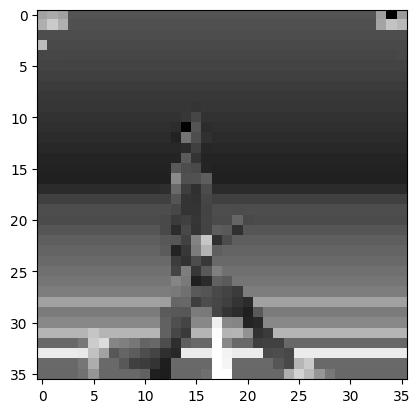

In [29]:
### Test environment wrapper methods

# Get current score
print(f"Score: {env.get_score()}")

# See if game is done
print(f"Done: {env.get_done()}")

# Get the current observation
obs = env.get_observation()
print(f"Shape: {obs.shape}")
plt.imshow(obs[0], cmap='gray')

In [105]:
### Test game loop

debug = False

# Do a few game loops
for ep in range(3):
    
    # Initialize game
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    
    # Do a single game loop
    while not terminated and not truncated:
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
        if debug:
            print(f"Score: {info['score']}, Time: {info['time']}, "
                  f"Terminated: {terminated}, Truncated: {truncated}")
        
    # Show results
    print(f"Total reward for episode {ep} is {total_reward}")

Total reward for episode 0 is 0.9
Total reward for episode 1 is -0.5
Total reward for episode 2 is 0.1


In [106]:
# Final environment check to make sure it works with Stable-Baselines3
env_checker.check_env(env)

### Train Model

In [72]:
# Create our environment with a timeout for training
try:
    env.close()
except NameError:
    pass
env = WebGame(timeout=60.0, disp_scale=DISP_SCALE_FACTOR, show_fps=True)

In [73]:
class SaveCheckpointCallback(BaseCallback):
    """
    Save the model every ``check_freq`` steps
    
    More information: https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html
    """
    
    # Constructor
    def __init__(self, check_freq, save_dir, verbose=1):
        super(SaveCheckpointCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_dir = save_dir
        
    # Create directory for saving the models
    def _init_callback(self):
        if self.save_dir is not None:
            os.makedirs(self.save_dir, exist_ok=True)
            
    # Save model every check_freq steps
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_dir, f"model_{self.n_calls}")
            self.model.save(model_path)
        return True

In [74]:
# Set up callback
callback = SaveCheckpointCallback(check_freq=10_000, save_dir=CHECKPOINT_DIR, verbose=1)

In [75]:
# Create model
# More information: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
model = PPO('CnnPolicy', 
            env, 
            verbose=0,
            tensorboard_log=LOG_DIR,
            learning_rate=0.0001, 
            n_steps=512)

In [107]:
# Choo choo train!
# total_timesteps: take at least this many steps, will stop on multiple of n_steps in PPO
# Host tensorboard on LAN: tensorboard --host 0.0.0.0 --logdir logs\PPO_n
# About logs: https://stable-baselines3.readthedocs.ioqqp/en/master/common/logger.html
# About plots: https://medium.com/aureliantactics/understanding-ppo-plots-in-tensorboard-cbc3199b9ba2
model.learn(total_timesteps=20_000, callback=callback)

KeyboardInterrupt: 

## Test model

In [108]:
# Create our environment for testing
try:
    env.close()
except NameError:
    pass
env = WebGame(timeout=60.0, disp_scale=DISP_SCALE_FACTOR, show_fps=True)

In [109]:
# Play game
for ep in range(3):
    
    # Reset game
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    step_count = 0
    
    # Perform actions based on observation and accumulate reward
    while not terminated and not truncated:
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(int(action))
        total_reward += reward
        step_count += 1
        
    # Print total reward at the end of the episode
    print(f"Episode {ep} | Steps: {step_count}, Total reward: {total_reward}")
    
    


Episode 0 | Steps: 7, Total reward: 0.9
Episode 1 | Steps: 11, Total reward: 1.3
Episode 2 | Steps: 10, Total reward: 1.3


In [104]:
# We're done! Close the environment
env.close()

## TODO:

 * Get FPS to show on window
 * Try learning
 * Add frame stacking
 * Add button combos (e.g. qw, qo, qp, wo, wp, op)